In [1]:
import os

if not os.getcwd().endswith('mob2crime'):
    os.chdir('..')
os.getcwd()

'/home/Jiahui/mob2crime'

In [44]:
import pandas as pd
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon
from src.creds import mex_root, mex_tower_08, mex_tower_12
from src.utils.gis import voronoi_finite_polygons_2d
import geopandas as gp
import folium
from src.utils.map_vis import geojson_per_row

In [3]:
from shapely.geometry import Point, LineString

In [4]:
# parameters

voz_only = True
debugging = True
tower_info_version = '08'


In [5]:
# vars dependent on paramaters

# level = logging.DEBUG if debugging else logging.INFO
# logging.basicConfig(filename="logs/MexTwHrUniqCnt.log", level=level, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

stat_dir = 'stats/MexTw%sHrUniqCntVOZ/' % tower_info_version
tower_info_path = {'08': mex_root+mex_tower_08, '12': mex_root+mex_tower_12}[tower_info_version]


In [14]:
towers = pd.read_csv(tower_info_path,header=None,sep='|')
towers['lonlat'] = towers.apply(lambda x: '%.6f'%(x[2])+','+'%.6f'%(x[3]), axis=1)
towers_gp = towers.groupby('lonlat')[0].apply(list).to_frame()
towers_gp['gtid'] = towers_gp[0].apply(lambda x: '-'.join(x))

gt2loc = {row['gtid']: loc.split(',') for loc, row in towers_gp.iterrows()}
t2gt = {}
for _, row in towers_gp.iterrows():
    for tid in row[0]:
        t2gt[tid] = row['gtid']

In [50]:
towers_shp = towers_gp.reset_index()

towers_shp['lonlat'] = towers_shp.lonlat.apply(lambda x: eval(x))
towers_shp['geometry'] = towers_shp.lonlat.apply(lambda x: Point(x))
towers_shp = gp.GeoDataFrame(towers_shp)

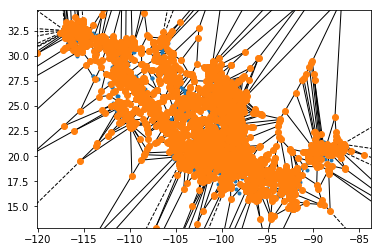

In [23]:
vor = Voronoi(towers_shp.lonlat.tolist())
voronoi_plot_2d(vor)
vor.close()

In [31]:
len(vor.points)

5731

In [47]:
def vor2gp(vor, radius=None, dataframe=False):
    
    regions, vertices = voronoi_finite_polygons_2d(vor, radius=radius)
    polys = [Polygon(vertices[r]) for r in regions]
    if dataframe:
        return gp.GeoDataFrame(polys,columns=['geometry'])
    return gp.GeoSeries(polys)

In [76]:
vor_polys = vor2gp(vor,dataframe=True)
vor_polys['gtid'] = towers_shp.gtid

In [77]:
vor_polys.to_file('data/mex_vor_08.geojson', driver='GeoJSON')

In [71]:
def point_per_row(gpdf, name, tip_cols=None, some_map=None):
    feature_group = folium.FeatureGroup(name=name)
    for row in gpdf.itertuples():
        tip = '<br>'.join(['%s: %s' % (col, getattr(row, col)) for col in tip_cols]) if tip_cols is not None else name
        folium.Marker((row.geometry.y, row.geometry.x), tooltip=tip, popup=tip).add_to(feature_group)
    if some_map is not None:
        feature_group.add_to(some_map)
    return feature_group

In [75]:
some_map = folium.Map(location=[19.381495, -99.139095], zoom_start=8)
geojson_per_row(vor_polys, 'vor', color='yellow', tip_cols=['index'],some_map=some_map)
point_per_row(towers_shp, 'tower', tip_cols=['gtid'],some_map=some_map)

folium.LayerControl().add_to(some_map)
some_map.save('tmp/mexico_voronoi_08.html')

# trying vor

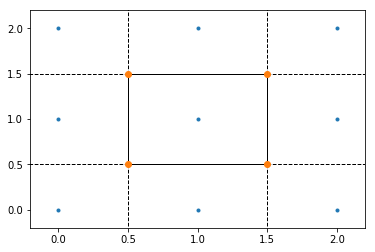

In [7]:
%matplotlib inline
points = [[0, 0], [0, 1], [1,0], [1,1], [2,0], [0,2],[2,2],[2,1],[1,2]]
region = Polygon([(5,-2),(5, 5),(-5,15),(-5,0)])

p_for_vor = points+region.boundary.coords[:-1]
vor = Voronoi(p_for_vor)
# voronoi_plot_2d(vor)
vor.close()
vor2 = Voronoi(points)
voronoi_plot_2d(vor2)
vor2.close()



In [38]:
def vor2gp(vor, radius=None):
    
    regions, vertices = voronoi_finite_polygons_2d(vor, radius=radius)

    pts = []
    polys = []
    for i in range(len(points)):
        pt = Point(points[i]).buffer(0.1)
        poly = Polygon(vertices[regions[i]])
        assert pt.intersects(poly)
        pts.append(pt)
        polys.append(poly)
    #     gp.GeoSeries([pt,poly.boundary]).plot()


    gp.GeoSeries(pts+[p.boundary for p in polys]+[region.boundary]).plot()

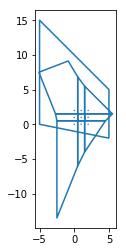

In [120]:
vor2gp(vor)

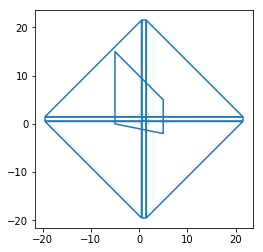

In [125]:
vor2gp(vor2, vor.points.ptp().max())